In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import thejoker
import scipy.stats
import GP_class
import george
import numpy.random as rnd

import sys
import time as tm

In [2]:
def read_data(filename, whitespace=False, datadir="./"):
    """
    Read in light curve data from asteroid.
    """

    data  = pd.read_csv(datadir+filename, header=None, delim_whitespace=whitespace)

    tsample = data[0]
    fsample = data[1]
    flux_err = data[2]

    return tsample, fsample, flux_err

time, flux, flux_err = read_data("../data/simulation_results_new/3200/3200_lc_49627_to_49787.txt_sampled_talc_14days.txt")

In [3]:
# 1 : set up the prior distriubtion

# try the  np norm distriubtion : np.random.norm
# as computing about timing scripts
# time it scipy vs numpy

prior_mean = scipy.stats.norm(1, 0.5)
prior_log_amp = scipy.stats.norm(np.log(0.15), np.log(2))
prior_log_gamma = scipy.stats.norm(np.log(10), np.log(2))
prior_log_period = scipy.stats.norm(np.log(4./24.), (12./24.))

In [4]:
%time
nsamples = 10**8

J_mean = prior_mean.rvs(nsamples)
J_log_amp = prior_log_amp.rvs(nsamples)
J_log_gamma = prior_log_gamma.rvs(nsamples)
J_log_period= prior_log_period.rvs(nsamples)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [5]:
#%timeit rnd.randn(1000000)

#J  = J*0.5 + np.log(4/24.)
# multiply by st dev and add mean

In [6]:
mean_flux = np.mean(flux)
log_amp = np.log(flux.max()-flux.min())
gamma = 1
log_period = 0

In [7]:
kernel = np.exp(log_amp) * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
gp = george.GP(kernel, fit_mean=True, mean=mean_flux)
gp.compute(time, flux_err)

In [8]:
def calculate_likelihood(i):
    params = [J_mean[i], J_log_amp[i], np.exp(J_log_gamma[i]), J_log_period[i]]
    gp.set_parameter_vector(params)

    try:
        #gp.compute(time, flux_err)
        lnlike = gp.log_likelihood(flux)
    except np.linalg.LinAlgError:
        lnlike = -1e25

    #L_results[i] = lnlike
    
    return lnlike

In [ ]:
#%%prun
# 2: for each j, calculate the log likelihood

L_results = np.ones(nsamples)

start_time = tm.time()

for i in np.arange(nsamples):

    p = ((i+1)/nsamples)*100
    if p.is_integer():
        sys.stdout.write('\r'+str(int(p))+"%")

    params = [J_mean[i], J_log_amp[i], np.exp(J_log_gamma[i]), J_log_period[i]]

    gp.set_parameter_vector(params)

    try:
        #gp.compute(time, flux_err)
        lnlike = gp.log_likelihood(flux)
    except np.linalg.LinAlgError:
        lnlike = -1e25

    L_results[i] = lnlike
        
end_time = tm.time()

print("\ntotal time taken for this loop: %.2f seconds" %(end_time - start_time))


In [9]:
import multiprocessing as mp
(mp.cpu_count())

96

In [10]:
# Parallelizing using Pool.map()
import multiprocessing as mp

# Redefine, with only 1 mandatory argument.
#def howmany_within_range_rowonly(row, minimum=4, maximum=8):
#    count = 0
#    for n in row:
#        if minimum <= n <= maximum:
#            count = count + 1
#    return count

#pool = mp.Pool(mp.cpu_count())

#results = pool.map(howmany_within_range_rowonly, [row for row in data])

#pool.close()



#print(results[:10])
########################################33
#start_time = tm.time()
#L_results = np.ones(nsamples)
start_time = tm.time()


pool = mp.Pool(40)

L_results = []
L_results = pool.map(calculate_likelihood, [i for i in np.arange(nsamples)])

pool.close()

end_time = tm.time()
print("\ntotal time taken for this loop: %.2f seconds" %(end_time - start_time))


total time taken for this loop: 3553.86 seconds


In [ ]:
(L_results[0])

In [ ]:
L_results = np.ones(nsamples)

start_time = tm.time()

with mp.Pool(processes=mp.cpu_count()) as p:
    max_ = nsamples
    with tqdm(total=max_) as pbar:
        for i, _ in tqdm_notebook(enumerate(p.imap_unordered(calculate_likelihood, np.arange(max_)))):
            pbar.update()
        pbar.close(); del pbar
            
end_time = tm.time()
print("\ntotal time taken for this loop: %.2f seconds" %(end_time - start_time))

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

ax[0,0].scatter(np.exp(J_log_period)*24., L_results)

L_max_period = np.exp(J_log_period[np.where(L_results==L_results.max())])*24.
ax[0,0].vlines(L_max_period, L_results.min(), L_results.max(), label="Lmax: %f" %L_max_period, linestyles='dashed', alpha=0.7)
ax[0,0].legend()
ax[0,0].set_title("Period (hours)")


ax[0,1].scatter(J_mean, L_results)

L_max_mean = J_mean[np.where(L_results==L_results.max())]
ax[0,1].vlines(L_max_mean, L_results.min(), L_results.max(), label="Lmax: %f" %L_max_mean, linestyles='dashed', alpha=0.7)
ax[0,1].legend()
ax[0,1].set_title("Mean")


ax[1,0].scatter(J_log_amp, L_results)

L_max_amp = np.exp(J_log_amp[np.where(L_results==L_results.max())])
ax[1,0].vlines(L_max_amp, L_results.min(), L_results.max(), label="Lmax: %f" %L_max_amp, linestyles='dashed', alpha=0.7)
ax[1,0].legend()
ax[1,0].set_title("Amplitude")

ax[1,1].scatter(np.exp(J_log_gamma), L_results)

L_max_gamma = np.exp(J_log_gamma[np.where(L_results==L_results.max())])
ax[1,1].vlines(L_max_gamma, L_results.min(), L_results.max(), label="Lmax: %f" %L_max_gamma, linestyles='dashed', alpha=0.7)
ax[1,1].legend()
ax[1,1].set_title("Gamma")

In [30]:
# 3 : Pick a random number r out of a uniform distribution between 0 and Lmax
uu = rnd.uniform(size=len(L_results))

good_samples_bool = 0.001 < np.exp(L_results-max(L_results))
good_samples_idx, = np.where(good_samples_bool)

len(good_samples_idx)

82

In [31]:
x= np.array(L_results)

In [32]:
x[good_samples_idx]

array([298.54085988, 300.44960104, 299.10563236, 299.64276378,
       299.36792584, 298.38981998, 298.38108271, 300.10195418,
       303.13469854, 299.30267272, 299.39218526, 303.36010507,
       298.46021259, 299.68710363, 299.85296169, 300.48352824,
       298.38614818, 299.38772124, 300.95715676, 301.97202762,
       299.94149389, 299.43278196, 298.35309397, 299.65420294,
       301.13572932, 303.02852755, 301.42311449, 298.67584611,
       303.57421372, 298.47436504, 302.99429229, 300.39691045,
       299.03182909, 298.55006503, 298.31126286, 298.32126772,
       300.1764921 , 298.54177052, 301.70120459, 299.42262896,
       298.97738265, 299.1293469 , 298.35939559, 300.07354782,
       303.32152274, 301.61934467, 299.64576533, 299.26967695,
       301.32813827, 299.61466794, 298.66417919, 298.25804878,
       300.7231801 , 300.48530225, 298.78690607, 301.82857602,
       300.93153264, 304.08383904, 300.40503571, 300.28321855,
       301.3194282 , 298.76233342, 301.92779558, 303.41

In [33]:
J_log_period[good_samples_idx]

array([-1.89612739, -1.89606669, -1.89608126, -1.89606177, -1.89603895,
       -1.89606262, -1.89603459, -1.89606597, -1.89609313, -1.89607185,
       -1.89607846, -1.89609191, -1.89603623, -1.89604059, -1.89607167,
       -1.89605339, -1.89600885, -1.89607652, -1.89606464, -1.89610632,
       -1.89603866, -1.89606694, -1.89600891, -1.8959952 , -1.89610996,
       -1.89609434, -1.89608571, -1.89609426, -1.89605149, -1.89610157,
       -1.89606712, -1.89605515, -1.89604225, -1.89613905, -1.89606685,
       -1.89602099, -1.89606978, -1.89611353, -1.89603712, -1.89604231,
       -1.89609283, -1.89609837, -1.89607163, -1.89605838, -1.89606859,
       -1.89605815, -1.89610848, -1.89600225, -1.89603579, -1.89602811,
       -1.89601883, -1.89610137, -1.89612409, -1.89602383, -1.89600405,
       -1.89607399, -1.896113  , -1.8960598 , -1.89611062, -1.89604032,
       -1.8960921 , -1.89601619, -1.89610171, -1.89606639, -1.896023  ,
       -1.89610849, -1.89608656, -1.89605427, -1.89608946, -1.89

(3.6035, 3.604)

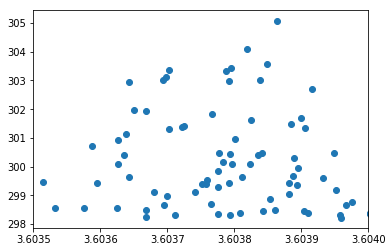

In [34]:
plt.scatter(np.exp(J_log_period[good_samples_idx])*24, x[good_samples_idx])
plt.xlim([3.6035, 3.6040])

In [ ]:
L_max_period = np.exp(J_log_period[np.where(L_results==max(L_results))])*24.


In [ ]:
L_max_period

In [ ]:
(np.nonzero(np.exp(L_results-max(L_results))))

In [ ]:
len(J_log_period)

In [ ]:
plt.scatter(np.exp(J_log_period)*24., np.exp(L_results-max(L_results)))

# plot l_max
L_max_period = np.exp(J_log_period[np.where(L_results==max(L_results))])*24.
plt.vlines(L_max_period, 0, 1, label="Lmax: %f" %L_max_period, linestyles='dashed', alpha=0.7)
plt.legend()

In [ ]:
plt.scatter(J_mean, np.exp(L_results-L_results.max()))

# plot l_max
L_max_mean = J_mean[np.where(L_results==L_results.max())]
plt.vlines(L_max_mean, 0, 1, label="Lmax: %f" %L_max_period, linestyles='dashed', alpha=0.7)
plt.legend()

In [ ]:
len(good_samples_idx)

In [ ]:
import plotting

In [ ]:
plotting.plot_folded_lightcurve(time, flux, period = np.exp(J_log_period[np.where(L_results==L_results.max())]))

In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

In [ ]:
import numpy as np
from time import time

# Prepare data
np.random.RandomState(100)
arr = np.random.randint(0, 10, size=[200000, 5])
data = arr.tolist()
data[:5]

In [ ]:
# Solution Without Paralleization

def howmany_within_range(row, minimum, maximum):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

results = []
for row in data:
    results.append(howmany_within_range(row, minimum=4, maximum=8))

print(results[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]

In [ ]:
# Parallelizing using Pool.apply()

import multiprocessing as mp

# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `howmany_within_range()`
results = [pool.apply(howmany_within_range, args=(row, 4, 8)) for row in data]

# Step 3: Don't forget to close
pool.close()    

print(results[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]

In [ ]:
# Parallelizing using Pool.map()
import multiprocessing as mp

# Redefine, with only 1 mandatory argument.
def howmany_within_range_rowonly(row, minimum=4, maximum=8):
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

pool = mp.Pool(mp.cpu_count())

results = pool.map(howmany_within_range_rowonly, [row for row in data])

pool.close()

print(results[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]